### Feature selection for Boston housing dataset

In [1]:
#Boston dataset
from sklearn.datasets import load_boston 

#Feature selection libraries:
from sklearn.feature_selection import SelectKBest,f_regression, mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel 
from sklearn.feature_selection import SequentialFeatureSelector

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Other important libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from tabulate import tabulate
from scipy.stats import pointbiserialr

In [2]:
boston_data = load_boston()
boston_x = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names']) # regressors
boston_y = boston_data['target']     

In [3]:
#For a description of this dataset
print(boston_data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Correlation Matrix
By visualizing the correlation matrix we can detect which are the variables that are highly correlated with the target value, and with other predictors. When several predictors are correlated with others we face the problem of multicollinearity, which means that we have redundant independent variables in our dataset. In this case, we should select a set of features that are independent from other features (low correlation) but correlated with the dependent variable.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(boston_x, boston_y, test_size=0.2, random_state=0)

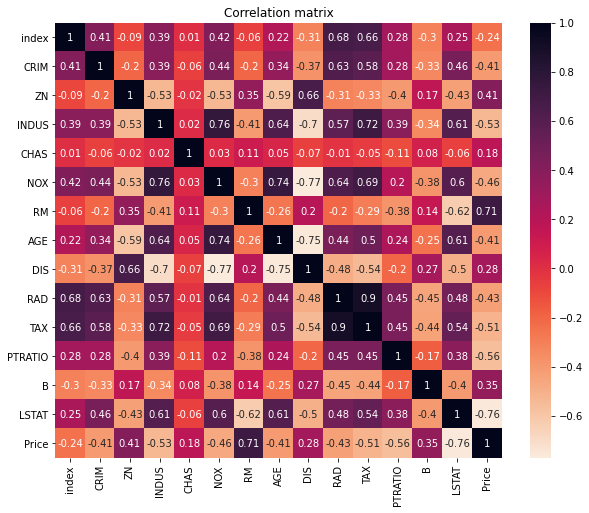

In [5]:
correlation_matrix = pd.concat([X_train.reset_index(),pd.Series(y_train,name="Price")],axis=1).corr().round(2)
plt.figure(figsize=(10,8))
cmap = sns.cm.rocket_r
sns.heatmap(data=correlation_matrix, annot=True,cmap=cmap)
plt.title("Correlation matrix");

Note: If one variable is continuous and the other is nominal with just two categories (just as CHAS that contains 0 and 1 values) it is recommended to calculate the point-biserial correlation coefficient, which is a special case of Pearson Correlation. Since the coefficient ranges between –1 and +1. <a href="https://journals.sagepub.com/doi/pdf/10.1177/8756479308317006">(Measures of Association How to Choose?).</a> 

A point-biserial correlation is simply the correlation between one dichotmous variable and one continuous variable. So computing the special point-biserial correlation is equivalent to computing the Pearson correlation when one variable is dichotmous and the other is continuous.

In [6]:
cont_var=pd.concat([X_train.reset_index(),pd.Series(y_train,name="Price")],axis=1)
coef=[]
for i in range(cont_var.shape[1]):
    coef.append((cont_var.columns[i],
                 np.round(pointbiserialr(X_train.reset_index()['CHAS'],cont_var.iloc[:,i])[0],2)))

In [7]:
pd.DataFrame(coef,columns=["Variable","Corr_Coef"])
#Same values as in the graph above

,Variable,Corr_Coef
0,index,0.01
1,CRIM,-0.06
2,ZN,-0.02
3,INDUS,0.02
4,CHAS,1.00
5,NOX,0.03
6,RM,0.11
7,AGE,0.05
8,DIS,-0.07
9,RAD,-0.01


## Right way to perform Cross-Validation:

Instead of just selecting the features by looking at the correlation matrix, we are going to follow the steps below to apply some of the feature selection methods available in scikit-learn[<sup>1</sup>](#fn1):

1. Divide the samples into K cross-validation folds (groups) at random.
2. For each fold k = 1, 2,... ,K:
   * Find a subset of “good” predictors that show fairly strong (univariate) correlation with the class labels, using all of the samples except those in fold k.
   * Using just this subset of predictors, build a multivariate classifier, using all of the samples except those in fold k.
   * Use the classifier to predict the class labels for the samples in fold k.

Why should we do it this way? Because, on the contrary, the features will be chosen based on all the samples, and this can lead to incorrect estimates when we try to use these features in a completely independent test set. This problem is also known as Information or Data Leakage[<sup>2</sup>](#fn2), which refers to the use of the test set data (or validation data) during the training process. 

With that been said, we are going to apply this procedure by using some of the supervised feature selection methods available in Scikit-Learn. The algorithms presented below are performed using a pipeline, to organize in a sequence the steps of the feature selection process and estimation of the house prices with the final subset of variables. Finally, this sequence will be introduced into a grid search to compute the cross-validation (5 folds) and to tune some of the hyperparameters.

## Feature selection methods

### I. Select features with the k highest scores[<sup>3</sup>](#fn3)

In this method we select the k features with the highest scores, which are measured by one of two functions since the target variable is continuous: f_regression or mutual_info_regression. 

1. f_regression: this is an univariate linear regression test. In other words, it tests the individual effect of each of the independent variables by calculating the correlation between each of these features individually with respect to the target and then obtain the F test which captures the linear dependency. After getting the corresponding F for each variable we look for its respective p value. For more information about the procedure this is the <a href="https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/feature_selection/_univariate_selection.py#L232">source code.</a>


2. mutual_info_regression: Mutual information can be described in this case as the amount of information obtained from the regressor and the continuous target. In this package the procedure used is based on entropy estimates from k-nearest neighbor distances. For more information about the procedure this is the <a href="https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/feature_selection/_mutual_info.py#L294">source code.</a>

In [8]:
regressor = GradientBoostingRegressor()

In [9]:
score_func=[f_regression,mutual_info_regression]
method =  SelectKBest()
pipe=Pipeline([("selectBest",method),("regressor",regressor)])

#selectBest__k refers to the number of top features to select, in this case we are going to try how many features (3, 6 or 9) maximizes the score function.   

result_1=GridSearchCV(pipe,{"selectBest__k":[3,6,9],"selectBest__score_func":score_func},cv=5,scoring="r2")

result_1.fit(X_train,y_train)

#Columns selected:
set_features_1=result_1.best_estimator_.named_steps["selectBest"]
selected=set_features_1.get_support(indices=True)
X_train.columns[selected]

Index(['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')

In [10]:
#F score
set_scores=result_1.best_estimator_.named_steps["selectBest"]
set_scores.scores_

array([ 81.77212064,  81.1475855 , 153.00493431,  13.09583263,
       107.63575126, 397.33191725,  82.83387891,  34.46704936,
        88.68548609, 142.08609712, 187.10308463,  57.67850087,
       535.13194094])

#### Observations:

After computing the feature selection using SelectKBest, the best combination of hyperparameters in this exercise correspond to 9 features which are: CRIM, INDUS, NOX, RM, AGE, RAD, TAX, PTRATIO, LSTAT, and the score function is f_regression.

In [11]:
#Which are the best parameters that maximize the scoring function?:
result_1.best_params_

{'selectBest__k': 9,
 'selectBest__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True)>}

In [12]:
df_results=[pd.DataFrame(result_1.cv_results_["params"]),
            pd.DataFrame(result_1.cv_results_["mean_test_score"]),
        pd.DataFrame(result_1.cv_results_["rank_test_score"])]
df_results=pd.concat(df_results,axis=1)
df_results.columns=["k_param","Score_functions","CV score","Rank"]
df_results

,k_param,Score_functions,CV score,Rank
0,3,<function f_regression at 0x0000023E290CC558>,0.835553,5
1,3,<function mutual_info_regression at 0x0000023E...,0.828327,6
2,6,<function f_regression at 0x0000023E290CC558>,0.881328,3
3,6,<function mutual_info_regression at 0x0000023E...,0.873912,4
4,9,<function f_regression at 0x0000023E290CC558>,0.882250,1
5,9,<function mutual_info_regression at 0x0000023E...,0.881430,2


In [13]:
#Predict new prices using the best hyperparameters found:
y_pred=result_1.predict(X_test)
RMSE_1=mean_squared_error(y_test,y_pred)**0.5
RMSE_1

4.630222403325874

### II. Select features with Recursive Feature Elimination[<sup>4</sup>](#fn4)

This method applies a machine learning model to select a specific number of features. The RFE starts with all features and compute a measure of importance for each variable and then eliminates one of the least important (or the specified number of features) in each iteration. This process of calculating the importance and pruning the features is repeated in the resulting subset of features from the previous iteration, until it reaches the number of features we specified.

For more information about the procedure this is the <a href="https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/feature_selection/_rfe.py">source code.</a>

In [14]:
selector = RFE(RandomForestRegressor(), step=1)

pipe=Pipeline([("RFE",selector),("regressor",regressor)])

#RFE__n_features_to_select refers to the number of features to select in this case (3, 6 or 9) 

result_2=GridSearchCV(pipe,{"RFE__n_features_to_select":[3,6,9],
                        "RFE__estimator__n_estimators":[300,500,700]},cv=5,scoring="r2")

result_2.fit(X_train,y_train)

#Columns selected:
set_features_2=result_2.best_estimator_.named_steps["RFE"]
selected=set_features_2.get_support(indices=True)
X_train.columns[selected]

Index(['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='object')

#### Observations:

After computing the feature selection using Recursive Feature Elimination, the best combination of hyperparameters in this exercise correspond to 9 features which are: CRIM, NOX, RM, AGE, DIS, TAX, PTRATIO, B, LSTAT, and the number of trees or estimators is 700.

In [15]:
#Which are the best parameters that maximize the scoring function?:
result_2.best_params_

{'RFE__estimator__n_estimators': 700, 'RFE__n_features_to_select': 9}

In [16]:
df_results=[pd.DataFrame(result_2.cv_results_["params"]),
            pd.DataFrame(result_2.cv_results_["mean_test_score"]),
        pd.DataFrame(result_2.cv_results_["rank_test_score"])]

df_results=pd.concat(df_results,axis=1)

df_results.columns=["RFE_estimators","RFE_n_features","CV score","Rank"]
df_results

,RFE_estimators,RFE_n_features,CV score,Rank
0,300,3,0.797204,8
1,300,6,0.860915,5
2,300,9,0.881013,2
3,500,3,0.796794,9
4,500,6,0.863468,4
5,500,9,0.879718,3
6,700,3,0.801333,7
7,700,6,0.860578,6
8,700,9,0.884263,1


In [17]:
#Predict new prices using the best hyperparameters found:
y_pred=result_2.predict(X_test)
RMSE_2=mean_squared_error(y_test,y_pred)**0.5
RMSE_2

4.154992813356004

### III. Select features by Feature importance with Select From Model[<sup>5</sup>](#fn5)

This method also uses a model to rank the variables according to their respective measure of importance. However, the main difference between this one and the RFE, is that it does not perform an iteration to prune the least important variables. In other words, it uses a base estimator which will select a specific set of features depending on the attribute applied to compute the scores for each variable (feature_importances_ in tree based models or coef_ for linear models).

For more information about the procedure this is the <a href="https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/feature_selection/_from_model.py">source code.</a>


In [18]:
#The threshold is equal to -np.inf in this case because we are going to select the features only based on max_features     
selector = SelectFromModel(RandomForestRegressor(),threshold=-np.inf) 

pipe=Pipeline([("SelectFromModel",selector),("regressor",regressor)])

#SelectFromModel__max_features refers to the maximum number of features to select in this case (3, 6 or 9)

result_3=GridSearchCV(pipe,{'SelectFromModel__max_features':[3,6,9],
                 'SelectFromModel__estimator__n_estimators': [300,500,700]},cv=5,scoring='r2')

result_3.fit(X_train,y_train)

#Columns selected:
set_features_3=result_3.best_estimator_.named_steps["SelectFromModel"]
selected=set_features_3.get_support(indices=True)
X_train.columns[selected]

Index(['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='object')

#### Observations:

After computing the feature selection using SelectFromModel, the best combination of hyperparameters in this exercise correspond to 9 features which are: CRIM, NOX, RM, AGE, DIS, TAX, PTRATIO, B, LSTAT, and the number of trees or estimators is 300.

In [19]:
#Which are the best parameters that maximize the scoring function?:
result_3.best_params_

{'SelectFromModel__estimator__n_estimators': 300,
 'SelectFromModel__max_features': 9}

In [20]:
df_results=[pd.DataFrame(result_3.cv_results_["params"]),
            pd.DataFrame(result_3.cv_results_["mean_test_score"]),
        pd.DataFrame(result_3.cv_results_["rank_test_score"])]

df_results=pd.concat(df_results,axis=1)

df_results.columns=["SelectFromModel_estimators","SelectFromModel_n_features","CV score","Rank"]
df_results

,SelectFromModel_estimators,SelectFromModel_n_features,CV score,Rank
0,300,3,0.793555,9
1,300,6,0.864169,5
2,300,9,0.885242,1
3,500,3,0.795157,8
4,500,6,0.864904,4
5,500,9,0.885002,2
6,700,3,0.795234,7
7,700,6,0.863506,6
8,700,9,0.880600,3


In [21]:
#Predict new prices using the best hyperparameters found:
y_pred=result_3.predict(X_test)
RMSE_3=mean_squared_error(y_test,y_pred)**0.5
RMSE_3

4.052069454475682

### IV. Select features by Sequential Feature Selection[<sup>6</sup>](#fn6)

This method uses a model to select a subset of features by performing an iteration process in two ways:

1. Direction="forward": We start with an empty set of features and then select one feature based on the cross-validation scoring parameter, the we add another feature of the remaining ones and proceed to select the best pair based on the cv scores and so on until we reach the set of features we desire.

* Direction="backward": Instead of initializing the algorithm with an empty set, we start with all the features and then proceed to remove one variable based on the scoring parameter and so on until we have deleted the necessary features to reach the limit.

For more information about the procedure this is the <a href="https://github.com/scikit-learn/scikit-learn/blob/15a949460dbf19e5e196b8ef48f9712b72a3b3c3/sklearn/feature_selection/_sequential.py">source code.</a>

In [22]:
#Direction=Forward
sfs = SequentialFeatureSelector(RandomForestRegressor(),scoring='r2')

pipe=Pipeline([("SequentialForward",sfs),("regressor",regressor)])

result_4=GridSearchCV(pipe,{'SequentialForward__n_features_to_select':[3,6,9],
                            'SequentialForward__estimator__n_estimators': [300,500,700]},cv=5,scoring='r2')

result_4.fit(X_train,y_train)
#Columns selected:
set_features_4=result_4.best_estimator_.named_steps["SequentialForward"]
selected=set_features_4.get_support(indices=True)
X_train.columns[selected]

Index(['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')

In [23]:
set_features_4=result_4.best_estimator_.named_steps["SequentialForward"]
set_features_4.get_support(indices=True)

array([ 0,  4,  5,  6,  7,  8,  9, 10, 12], dtype=int64)

#### Observations:

After computing the feature selection using forward Sequential Feature Selector, the best combination of hyperparameters in this exercise correspond to 9 features which are: CRIM, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT, and the number of trees or estimators is 300.

In [24]:
#Which are the best parameters that maximize the scoring function?:
result_4.best_params_

{'SequentialForward__estimator__n_estimators': 300,
 'SequentialForward__n_features_to_select': 9}

In [25]:
df_results=[pd.DataFrame(result_4.cv_results_["params"]),
            pd.DataFrame(result_4.cv_results_["mean_test_score"]),
        pd.DataFrame(result_4.cv_results_["rank_test_score"])]

df_results=pd.concat(df_results,axis=1)

df_results.columns=["SequentialForward_estimators","SequentialForward_n_features","CV score","Rank"]
df_results

,SequentialForward_estimators,SequentialForward_n_features,CV score,Rank
0,300,3,0.854915,8
1,300,6,0.868273,6
2,300,9,0.882502,1
3,500,3,0.855890,7
4,500,6,0.874055,5
5,500,9,0.878651,4
6,700,3,0.849011,9
7,700,6,0.881122,3
8,700,9,0.881493,2


In [26]:
#Predict new prices using the best hyperparameters found:
y_pred=result_4.predict(X_test)
RMSE_4=mean_squared_error(y_test,y_pred)**0.5
RMSE_4

4.017163286801456

In [27]:
#Direction=Backward
sbs = SequentialFeatureSelector(RandomForestRegressor(),direction="backward",scoring='r2')
pipe=Pipeline([("SequentialBackward",sbs),
               ("regressor",regressor)])

result_5=GridSearchCV(pipe,{'SequentialBackward__n_features_to_select':[3,6,9],
                 'SequentialBackward__estimator__n_estimators': [300,500,700]},cv=5,scoring='r2')
result_5.fit(X_train,y_train)

#Columns selected:
set_features_5=result_5.best_estimator_.named_steps["SequentialBackward"]
selected=set_features_5.get_support(indices=True)
X_train.columns[selected]

Index(['NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')

In [28]:
set_features_5=result_5.best_estimator_.named_steps["SequentialBackward"]
set_features_5.get_support(indices=True)

array([ 4,  5,  7,  9, 10, 12], dtype=int64)

#### Observations:

After computing the feature selection using backward Sequential Feature Selector, the best combination of hyperparameters in this exercise correspond to 6 features which are: NOX, RM, DIS, TAX, PTRATIO, LSTAT, and the number of trees or estimators is 700.

In [29]:
#Which are the best parameters that maximize the scoring function?:
result_5.best_params_

{'SequentialBackward__estimator__n_estimators': 700,
 'SequentialBackward__n_features_to_select': 6}

In [30]:
df_results=[pd.DataFrame(result_5.cv_results_["params"]),
            pd.DataFrame(result_5.cv_results_["mean_test_score"]),
        pd.DataFrame(result_5.cv_results_["rank_test_score"])]

df_results=pd.concat(df_results,axis=1)

df_results.columns=["SequentialBackward_estimators","SequentialBackward_n_features","CV score","Rank"]
df_results

,SequentialBackward_estimators,SequentialBackward_n_features,CV score,Rank
0,300,3,0.844962,7
1,300,6,0.872264,4
2,300,9,0.853544,6
3,500,3,0.832805,8
4,500,6,0.875572,3
5,500,9,0.866320,5
6,700,3,0.828811,9
7,700,6,0.885642,1
8,700,9,0.875683,2


In [31]:
y_pred=result_5.predict(X_test)
RMSE_5=mean_squared_error(y_test,y_pred)**0.5
RMSE_5

4.0734005144739065

### Comparison of techniques

In [46]:
#No feature selection applied
result_no_fs=GridSearchCV(regressor,{'n_estimators':[100,300,500]},cv=5,scoring='r2')
result_no_fs.fit(X_train,y_train)
result_no_fs.best_params_

{'n_estimators': 500}

In [47]:
best_test_score=max(result_no_fs.cv_results_["mean_test_score"])

In [48]:
y_pred=result_no_fs.predict(X_test)
RMSE_no_fs=mean_squared_error(y_test,y_pred)**0.5
RMSE_no_fs

4.113109858706576

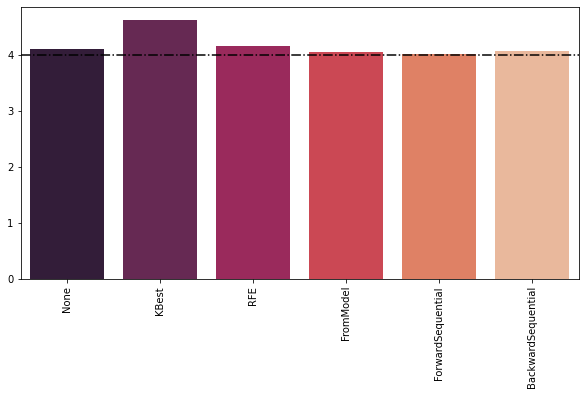

In [49]:
values_rmse=[RMSE_no_fs,RMSE_1,RMSE_2,RMSE_3,RMSE_4,RMSE_5]
x=["None","KBest","RFE","FromModel","ForwardSequential","BackwardSequential"]

plt.figure(figsize=(10,5))
plot=sns.barplot(x=x,y=values_rmse,palette="rocket")
plot.axhline(4.0,color='black',linestyle='-.')
plt.xticks(rotation=90)
plt.show()

### Combination of techniques

This is just another way to compute the process of feature selection and estimation of the house prices in one place and compare different techniques.    

In [50]:
options=[]

options.append(('Option 1' , (Pipeline([('feature_selection',SelectKBest(f_regression)),
                                         ('regressor' ,regressor)])),
                {"feature_selection__k":[3,6,9],
                 'regressor__n_estimators':[100,300,500]}))

options.append(('Option 2' , (Pipeline([('feature_selection' , RFE(RandomForestRegressor(), step=1)),
                                         ('regressor' ,regressor)])),
               {'feature_selection__estimator':[RandomForestRegressor(),DecisionTreeRegressor()],
                'feature_selection__n_features_to_select': [3,6,9],
                'regressor__n_estimators':[100,300,500]}))

model_name = []
best_params = []
test_score=[]
features=[]
RMSE_pred=[]

for pipe,model,params in options:
    
    result=GridSearchCV(model,params,cv=5,scoring='r2')
    
    result.fit(X_train,y_train)    
    
    y_pred=result.predict(X_test)
    
    RMSE=mean_squared_error(y_test,y_pred)**0.5
    
    RMSE_pred.append(RMSE)
    
    best_params.append(result.best_params_)
    
    test_score.append(max(result.cv_results_["mean_test_score"]))
    
    model_name.append(pipe)
    
    fs=result.best_estimator_.named_steps["feature_selection"]
    
    features.append(fs.get_support(indices=True).tolist())

In [51]:
best_params[0]

{'feature_selection__k': 9, 'regressor__n_estimators': 300}

In [52]:
best_params[1]

{'feature_selection__estimator': RandomForestRegressor(),
 'feature_selection__n_features_to_select': 9,
 'regressor__n_estimators': 300}

In [53]:
test_score

[0.888742378287057, 0.8891533095793734]

In [54]:
model_name

['Option 1', 'Option 2']

In [55]:
RMSE_pred

[4.6048622890550766, 3.9682506517701075]

In [56]:
table = [["Feature selection method","Test CV score","RMSE"],
         ["None",best_test_score,RMSE_no_fs], ['SelectKBest', test_score[0],RMSE_pred[0]],
         ['RFE', test_score[1],RMSE_pred[1]]]
print(tabulate(table, headers='firstrow'))

Feature selection method      Test CV score     RMSE
--------------------------  ---------------  -------
None                               0.885694  4.11311
SelectKBest                        0.888742  4.60486
RFE                                0.889153  3.96825


### Reference:

<span id="fn1">[1] Hastie, T., Tibshirani, R., & Friedman, J. (2009). The elements of statistical learning: data mining, inference, and prediction. Springer Science & Business Media.</span>

<span id="fn2">[2] Kuhn, Max, and Kjell Johnson. Feature engineering and selection: A practical approach for predictive models. CRC Press, 2019.</span>

<span id="fn3">[3] <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html">Scikit-learn feature selection: SelectKBest.</a> </span>

<span id="fn4">[4] <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html">Scikit-learn feature selection: RFE.</a> </span>

<span id="fn5">[5] <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html">Scikit-learn feature selection: SelectFromModel.</a> </span>

<span id="fn6">[6] <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html">Scikit-learn feature selection: SequentialFeatureSelector.</a> </span>


#### Others:

*  <a href="https://machinelearningmastery.com/rfe-feature-selection-in-python/#:~:text=RFE%20is%20a%20wrapper%2Dtype%20feature%20selection%20algorithm.&text=This%20is%20achieved%20by%20fitting,specified%20number%20of%20features%20remains">Recursive Feature Elimination (RFE) for Feature Selection in Python.</a>

* <a href="https://machinelearningmastery.com/regression-metrics-for-machine-learning/#:~:text=There%20are%20three%20error%20metrics,Mean%20Absolute%20Error%20(MAE)">Regression Metrics for Machine Learning.</a>